In [1]:
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from datetime import datetime, timezone, timedelta
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xmitgcm as xm
import time
import socket

# %matplotlib notebook

In [2]:
from datalakes import download_data_from_datalakes_dataset
from alplakes import parse_alplakes_3d_timeserie_from_directory, get_3d_profile_from_api, open_json, parse_json_3d_profile_to_df, parse_alplakes_1d_from_directory, parse_alplakes_json_3d_timeserie_to_df,parse_alplakes_json_profile_to_df
from utils import save_json
from mitgcm.utils_mitgcm import open_mitgcm_ds_from_config

# Comparison between MITgcm results, simstrat results (from Alplakes) and measurements from Datalakes
This notebook displays :
- the timeserie of the temperature at a given location and depth
- the profile of the temperature at a given location and time
- the heatmap of the profile at a given location

It imports the measure from a netcdf file that can be dowloaded on the datalake platform (https://www.datalakes-eawag.ch/data).
It imports local MITgcm simulation results.

In [3]:
lake_name = "Lake Neuch"
sta_name = 'center_neuch'

model = 'test_zurich'

In [4]:
var_to_plot = 'THETA'

In [5]:
with open(os.path.join('config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
xc_mitgcm_station = config_points['xc_mitgcm_200m']
yc_mitgcm_station = config_points['yc_mitgcm_200m']
xc_mitgcm_station
yc_mitgcm_station

5388

## Import MITgcm results

In [14]:
#mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('mitgcm/config.json', model)

output_dir = "/storage/alplakes_test/Soren/lake_ne/run_2024_25/crop_output"
output_file = os.path.join(output_dir, f"{sta_name}_cropped.nc")
xr_mitgcm =  xr.open_dataset(output_file)
xr_mitgcm

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 4136, Z: 78)
Coordinates: (12/29)
    XC       float32 4B ...
    YC       float32 4B ...
    XG       float32 4B ...
    YG       float32 4B ...
  * Z        (Z) float32 312B -0.25 -0.7575 -1.281 ... -141.5 -145.0 -147.9
    rA       float32 4B ...
    ...       ...
    rhoRef   (Z) float32 312B ...
    dyF      float32 4B ...
    dxF      float32 4B ...
    dxV      float32 4B ...
    iter     (time) int64 33kB ...
  * time     (time) datetime64[ns] 33kB 2024-01-01T01:30:08 ... 2025-05-31T22...
Data variables:
    THETA    (time, Z) float32 1MB ...
    UVEL     (time, Z) float32 1MB ...
    VVEL     (time, Z) float32 1MB ...
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

# Import timeseries

In [7]:
#ds_to_plot['time']

In [8]:
start_date = pd.to_datetime(ds_to_plot['time'].values[0],utc=True).to_pydatetime()  #datetime(2024, 1, 1, 0, 0, 0)
end_date = pd.to_datetime(ds_to_plot['time'].values[-1],utc=True).to_pydatetime() #datetime(2025, 1, 1, 0, 0, 0)
start_date

datetime.datetime(2024, 1, 1, 1, 30, 8, tzinfo=datetime.timezone.utc)

 ### 1. Hydronaut or Delft3D

In [97]:
#xr_measure = xr.open_dataset(f'./data/datalakes/geneva_idronaut/2024.nc')
#xr_measure = xr.open_dataset(f'C:/Users/rasmusso/Documents/ZH/data/measurement kanton/zurich_profile_2024.xlsx')

json_folder = f"data/alplakes_3d/{sta_name}/timeseries_0m"

alplakes_timeseries = parse_alplakes_3d_timeserie_from_directory(json_folder)

alplakes_timeseries['time'] = pd.to_datetime(alplakes_timeseries['time'])
alplakes_timeseries = alplakes_timeseries.sort_values(by='time', ascending=True)
filtered_alplakes = alplakes_timeseries[alplakes_timeseries['time'] >= pd.to_datetime(start_date)]
print(filtered_alplakes.tail())

                         time  temperature
236 2024-09-30 12:00:00+00:00       18.309
237 2024-09-30 15:00:00+00:00       18.611
238 2024-09-30 18:00:00+00:00       18.546
239 2024-09-30 21:00:00+00:00       18.407
240 2024-10-01 00:00:00+00:00       18.294


### 2. Measurements

                            time  temperature
4318   2024-03-04 01:00:04+00:00          7.2
4319   2024-03-04 01:01:04+00:00          7.2
4320   2024-03-04 01:02:04+00:00          7.1
4321   2024-03-04 01:03:05+00:00          7.2
4322   2024-03-04 01:04:05+00:00          7.2
...                          ...          ...
250864 2024-08-28 06:27:56+00:00         21.0
250865 2024-08-28 06:28:56+00:00         21.1
250866 2024-08-28 06:29:56+00:00         21.0
250867 2024-08-28 06:30:57+00:00         21.1
250868 2024-08-28 06:31:57+00:00         21.0

[246551 rows x 2 columns]


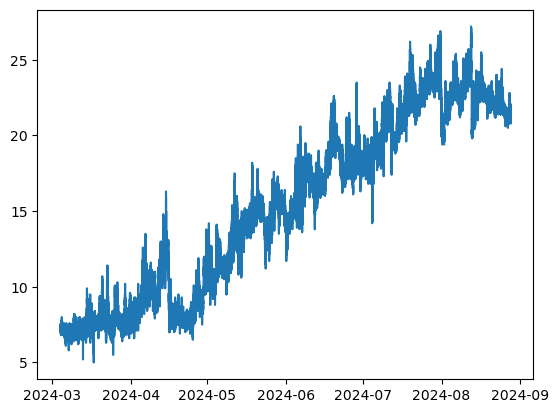

In [23]:
measurement_file = rf'data/alplakes_3d/{sta_name}/measurements/{sta_name}_data.csv' 
#measurement_file2 = rf'data/alplakes_3d/{sta_name}/measurements/{sta_name}_data_end.csv' 

#use xlsx or csv instead of nc to read the measurements
#df = pd.read_excel(measurement_file,header=1, engine='openpyxl')
df1 = pd.read_csv(measurement_file)
#df2 = pd.read_csv(measurement_file2)

df1['time'] = pd.to_datetime(df1['time'], utc=True)
#df2['timestamp'] = pd.to_datetime(df2['timestamp'], utc=True)
#df = pd.concat([df1, df2])
#df = df.drop_duplicates(subset='timestamp', keep='first')
mask = (df1['time'] >= start_date) & (df1['time'] <= end_date)
adjusted_meas = df1.loc[mask]
adjusted_meas = adjusted_meas.sort_values(by='time', ascending=True)
adjusted_meas = adjusted_meas[adjusted_meas['temperature'] <= 35]
print(adjusted_meas)
plt.plot(adjusted_meas.time, adjusted_meas.temperature)

xr_measure = download_data_from_datalakes_dataset(667, start_date.replace(tzinfo=timezone.utc), end_date.replace(tzinfo=timezone.utc), "idronaut")

### 3. Import simstrat alplakes 1d 

In [9]:
folder_path = '../simstrat_data'
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

## Plot timeseries temperature at depth "depth_simu"
#### dataklakes

depth_plot=-1 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

if xr_measure is not None:
    meas_selected = xr_measure['temperature']#.sel(depth=depth_plot, method='nearest') #.sel(time=slice(start_date,end_date))
    meas_selected.plot(label=f'Measure Idronaut', color='r')

#simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest') #.sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

#plt.savefig(rf"output_plots\{lake_name}\geneva_1year_200m_{depth_plot}m.png")

### alplakes

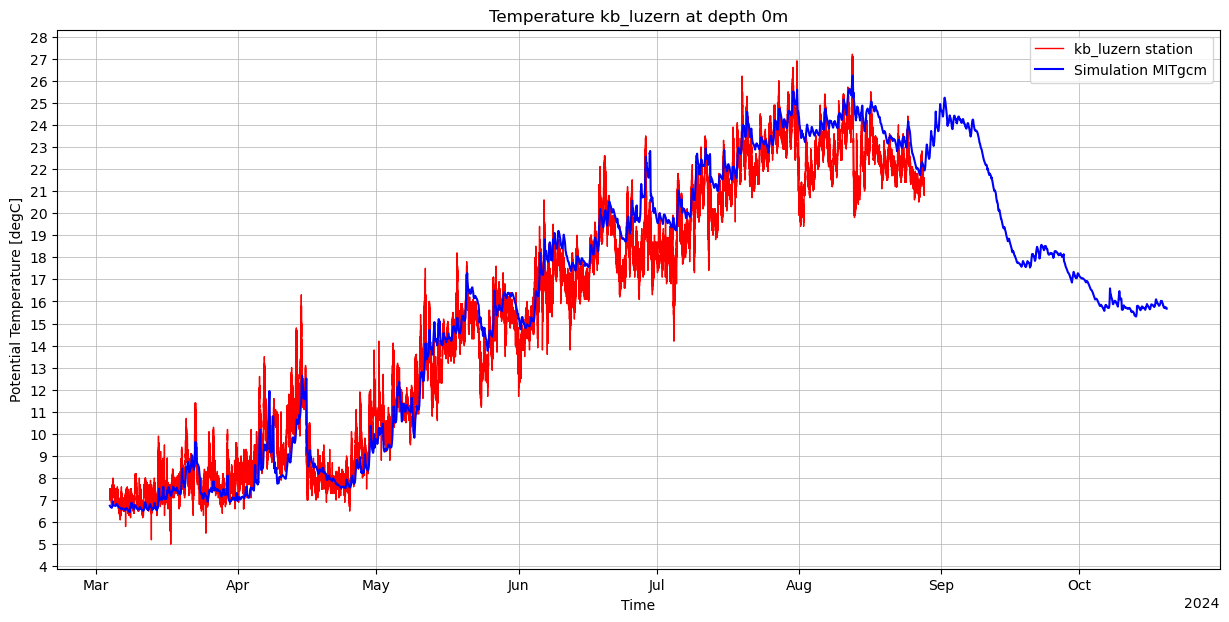

In [25]:
depth_plot=0 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

#if alplakes_timeseries is not None:
    #meas_selected = xr_measure['temperature']#.sel(depth=depth_plot, method='nearest') #.sel(time=slice(start_date,end_date))
    #plt.scatter(filtered_alplakes['time'],filtered_alplakes['temperature'],label=f'Delft3D', marker='+', s=3, c='orange')

#simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')
plt.plot(adjusted_meas.time,adjusted_meas.temperature, label=rf'{sta_name} station',color='r', lw=1)

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest') #.sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")
plt.savefig(rf"output_plots/timeseries_{sta_name}_{depth_plot}m_100.png")
plt.show()

# Import Profile

## 1. measurements canton

In [89]:
month = 11
measurement_file = rf'data/alplakes_3d/{sta_name}/measurements/{sta_name}_data.xlsx' 
#use xlsx or csv instead of nc to read the measurements
df = pd.read_excel(measurement_file,header=0, engine='openpyxl')
profile_dates_list = df.columns[1:].to_list()
#profile_dates = [ v.strftime("%Y.%m.%d %H:%M:%S") for v in profile_dates_list]
profile_dates = [
    datetime.strptime(date_str, "%d.%m.%Y %H:%M:%S GMT%z")#.strftime("%Y-%m-%d %H:%M")
    for date_str in profile_dates_list]
profile_dates = [t.replace(tzinfo=None) for t in profile_dates]
print(profile_dates_list)
hours = timedelta(hours=19)
#date_plot_profil = df.columns[month] + hours
date_plot_profil = profile_dates[month-1]

date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')
print(date_plot_profil)

['19.01.2024 13:00:00 GMT+0100', '14.02.2024 13:00:00 GMT+0100', '14.03.2024 13:00:00 GMT+0100', '11.04.2024 14:00:00 GMT+0200', '16.05.2024 14:00:00 GMT+0200', '13.06.2024 14:00:00 GMT+0200', '11.07.2024 14:00:00 GMT+0200', '15.08.2024 14:00:00 GMT+0200', '19.09.2024 14:00:00 GMT+0200', '09.10.2024 14:00:00 GMT+0200', '14.11.2024 13:00:00 GMT+0100', '16.01.2025 13:00:00 GMT+0100', '12.02.2025 13:00:00 GMT+0100', '13.03.2025 13:00:00 GMT+0100']
2024-11-14 13:00:00


## 2. alpales profiles

In [90]:
#with open(f"data/alplakes_3d/{sta_name}/profile/{date_plot_profil_str}.json", 'r') as file:
 #   alplakes_json = json.load(file)
#alplakes_profile = parse_alplakes_json_profile_to_df(alplakes_json)
#alplakes_profile

## 3. simstrat 1D

In [91]:
folder_path = '../simstrat_data'
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

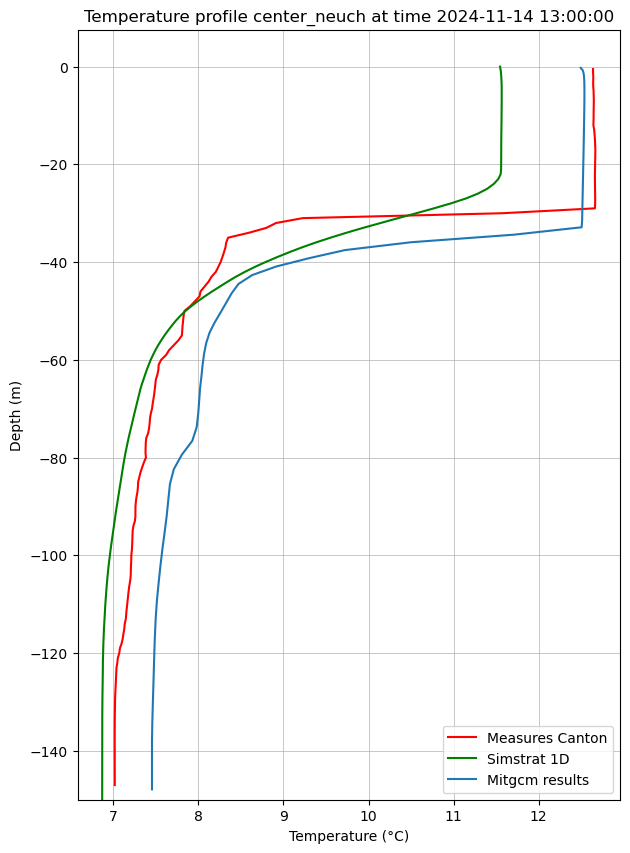

In [92]:
fig = plt.figure(figsize=(7, 10))

#meas_profile = xr_measure['temp'].sel(time=date_plot_profil, method='nearest')
#plt.plot(meas_profile.values, meas_profile.depth.values, label=f'Measure Idronaut', color='r')

# plot the xlsx format, just change the DATE
plt.plot(df[df.columns[month]],-1*df.Depth, label=f'Measures Canton', color='r')

#plt.plot(alplakes_profile.temperature,-1*alplakes_profile.depth, label=f'Delft3d', color='orange')
# Convert Simstrat depth to negative and plot
simstrat_depth_negative = -simstrat_data['depth'].values  # Convert to negative NumPy array
simstrat_temperature = simstrat_data['temperature'].sel(time=date_plot_profil, method='nearest')
plt.plot(simstrat_temperature.values, simstrat_depth_negative, label='Simstrat 1D', color='g')

##  if you loaded the whole reuslt file
#profile_to_plot = ds_to_plot['THETA'].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest').isel(time=0)
#profile_to_plot.where(profile_to_plot != 0, np.nan).plot(y='Z', label='Simulation MITgcm', color='b')

##If you loaded the given point file results

profile_mitgcm = xr_mitgcm['THETA'].sel(time=date_plot_profil, method='nearest')
profile_mitgcm.where(profile_mitgcm != 0, np.nan).plot(y='Z', label='Mitgcm results')
    
plt.title(f"Temperature profile {sta_name} at time {date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.ylim(bottom=-150)
plt.xlabel('Temperature (°C)')
plt.legend(loc='lower right')
plt.savefig(rf"{sta_name}_profile_{date_plot_profil.date()}_UTC.png")
plt.show()